# Import Library dan Dataset

In [1]:
# Import Libraries
import os
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
import os
import shutil
import pandas as pd
import gdown

# === TensorFlowJS & Model Konversi ===
!pip install tensorflowjs
import tensorflowjs as tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Link Google Drive (file ID dari URL)
file_id = '1_yILen_J-2kuN-jzzIa127nEw_pMw-AD'
gdown_url = f'https://drive.google.com/uc?id={file_id}'

# Path penyimpanan dan ekstraksi
zip_path = '/content/300_Copy.zip'
extract_path = '/content/extracted_dataset'

# Unduh file dari Google Drive
gdown.download(gdown_url, zip_path, quiet=False)

# Ekstrak file ZIP
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset berhasil diekstrak ke: {extract_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1_yILen_J-2kuN-jzzIa127nEw_pMw-AD
From (redirected): https://drive.google.com/uc?id=1_yILen_J-2kuN-jzzIa127nEw_pMw-AD&confirm=t&uuid=e3514b56-cf41-4bfa-b5bf-274a881eeec7
To: /content/300_Copy.zip
100%|██████████| 319M/319M [00:05<00:00, 56.5MB/s]


Dataset berhasil diekstrak ke: /content/extracted_dataset


#EDA

In [3]:
import os
categories = [folder for folder in os.listdir('/content/extracted_dataset/300 - Copy') if os.path.isdir(os.path.join('/content/extracted_dataset/300 - Copy', folder))]
print("Daftar kategori yang tersedia:")
for category in sorted(categories):
    print(category)

Daftar kategori yang tersedia:
chicken_curry
chicken_wings
churros
club_sandwich
french_fries
fried_calamari
fried_rice
ice_cream
lasagna
macaroni_and_cheese
omelette
pancakes
pizza
pork_chop
ramen
spaghetti_bolognese
spaghetti_carbonara
sushi
tacos
tiramisu


In [4]:
import os
import shutil
import random

# Kategori berdasarkan klasifikasi gizi
balanced_categories = [
    "chicken_curry", "fried_rice", "omelette", "pork_chop", "spaghetti_carbonara",
    "ramen", "macaroni_and_cheese", "club_sandwich", "sushi", "lasagna"
]

unbalanced_categories = [
    "chicken_wings", "churros", "french_fries", "fried_calamari", "ice_cream",
    "pancakes", "pizza", "spaghetti_bolognese", "tacos", "tiramisu"
]

# Lokasi dataset asli dan direktori tujuan
base_dir = '/content/extracted_dataset/300 - Copy'  # Ubah sesuai lokasi aslinya
output_dir = 'food101_split_binary'
os.makedirs(output_dir, exist_ok=True)

# Membuat struktur direktori untuk setiap split dan label
splits = ['train', 'val', 'test']
labels = ['seimbang', 'tidak_seimbang']

for split in splits:
    for label in labels:
        os.makedirs(os.path.join(output_dir, f'{split}/{label}'), exist_ok=True)

# Fungsi untuk membagi dan menyalin gambar
def split_dataset(categories, label):
    for category in categories:
        src_dir = os.path.join(base_dir, category)
        if not os.path.exists(src_dir):
            print(f"[!] Folder kategori tidak ditemukan: {category}")
            continue

        all_images = os.listdir(src_dir)
        random.shuffle(all_images)

        total = len(all_images)
        train_count = int(0.75 * total)
        val_count = int(0.10 * total)
        test_count = total - train_count - val_count

        split_counts = {
            'train': train_count,
            'val': val_count,
            'test': test_count
        }

        start_idx = 0
        for split in splits:
            split_path = os.path.join(output_dir, f'{split}/{label}/{category}')
            os.makedirs(split_path, exist_ok=True)
            end_idx = start_idx + split_counts[split]
            for img in all_images[start_idx:end_idx]:
                shutil.copy(os.path.join(src_dir, img), os.path.join(split_path, img))
            print(f"[✓] {category} → {split}/{label} ({split_counts[split]} gambar)")
            start_idx = end_idx

# Jalankan proses untuk dua kategori
split_dataset(balanced_categories, 'seimbang')
split_dataset(unbalanced_categories, 'tidak_seimbang')

print("\n📁 Dataset berhasil dibagi menjadi train (75%), val (10%), dan test (15%).")


[✓] chicken_curry → train/seimbang (243 gambar)
[✓] chicken_curry → val/seimbang (32 gambar)
[✓] chicken_curry → test/seimbang (49 gambar)
[✓] fried_rice → train/seimbang (243 gambar)
[✓] fried_rice → val/seimbang (32 gambar)
[✓] fried_rice → test/seimbang (49 gambar)
[✓] omelette → train/seimbang (243 gambar)
[✓] omelette → val/seimbang (32 gambar)
[✓] omelette → test/seimbang (49 gambar)
[✓] pork_chop → train/seimbang (243 gambar)
[✓] pork_chop → val/seimbang (32 gambar)
[✓] pork_chop → test/seimbang (49 gambar)
[✓] spaghetti_carbonara → train/seimbang (243 gambar)
[✓] spaghetti_carbonara → val/seimbang (32 gambar)
[✓] spaghetti_carbonara → test/seimbang (49 gambar)
[✓] ramen → train/seimbang (243 gambar)
[✓] ramen → val/seimbang (32 gambar)
[✓] ramen → test/seimbang (49 gambar)
[✓] macaroni_and_cheese → train/seimbang (243 gambar)
[✓] macaroni_and_cheese → val/seimbang (32 gambar)
[✓] macaroni_and_cheese → test/seimbang (49 gambar)
[✓] club_sandwich → train/seimbang (243 gambar)
[✓]

# Exploratory Data Analysis (EDA)

In [5]:
import os

# Misal: output_dir = folder tempat train/val/test berada
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = sum([len(files) for _, _, files in os.walk(class_path)])
            class_counts[class_name] = count
    return class_counts

# Hitung jumlah gambar per kelas untuk tiap set
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Tampilkan hasil distribusi
print("\nDistribusi Gambar per Kelas:")

print("\nTrain:")
for cls, count in sorted(train_counts.items()):
    print(f"  {cls}: {count} gambar")

print("\nValidasi:")
for cls, count in sorted(val_counts.items()):
    print(f"  {cls}: {count} gambar")

print("\nTest:")
for cls, count in sorted(test_counts.items()):
    print(f"  {cls}: {count} gambar")

# Total keseluruhan
total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
total_test = sum(test_counts.values())
total_all = total_train + total_val + total_test

print(f"\nTotal gambar di train    : {total_train}")
print(f"Total gambar di validasi : {total_val}")
print(f"Total gambar di test     : {total_test}")
print(f"Total seluruh gambar     : {total_all}")



Distribusi Gambar per Kelas:

Train:
  seimbang: 2430 gambar
  tidak_seimbang: 2430 gambar

Validasi:
  seimbang: 320 gambar
  tidak_seimbang: 320 gambar

Test:
  seimbang: 490 gambar
  tidak_seimbang: 490 gambar

Total gambar di train    : 4860
Total gambar di validasi : 640
Total gambar di test     : 980
Total seluruh gambar     : 6480


<ipython-input-6-b78b1e95220f>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=values, ax=axes[i], palette="viridis")
<ipython-input-6-b78b1e95220f>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=values, ax=axes[i], palette="viridis")
<ipython-input-6-b78b1e95220f>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=labels, x=values, ax=axes[i], palette="viridis")


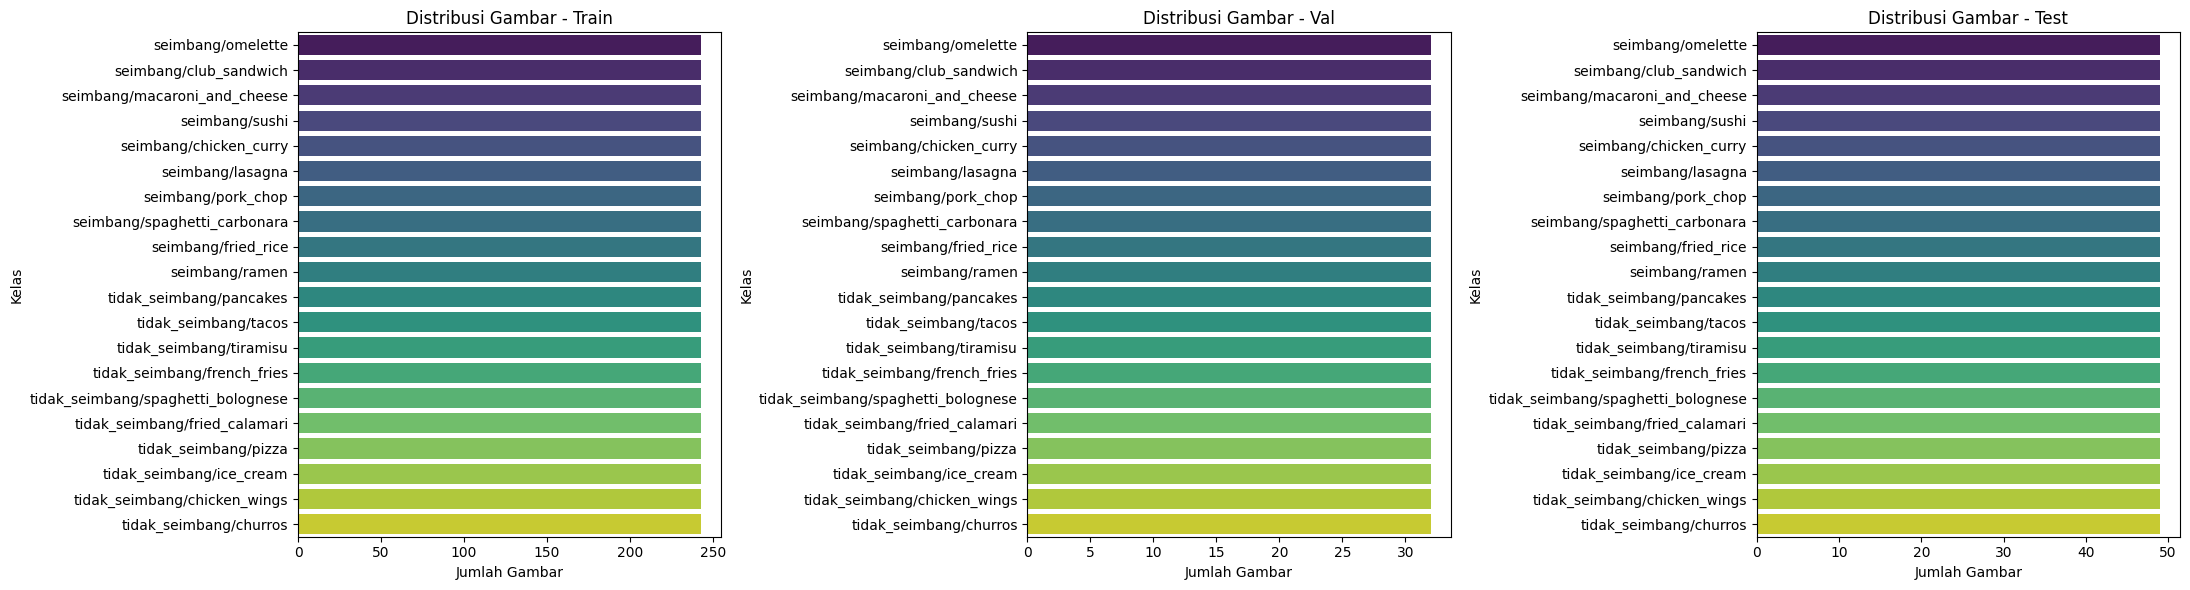

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path ke folder utama
base_dir = "food101_split_binary"  # Ganti ini jika perlu
splits = ['train', 'val', 'test']

# Fungsi untuk menghitung jumlah gambar per subfolder dalam kategori
def count_images_nested(base_path):
    counts = {}
    for kategori in os.listdir(base_path):  # seimbang / tidak_seimbang
        kategori_path = os.path.join(base_path, kategori)
        if os.path.isdir(kategori_path):
            for sub_kelas in os.listdir(kategori_path):  # misalnya chicken_curry
                sub_kelas_path = os.path.join(kategori_path, sub_kelas)
                if os.path.isdir(sub_kelas_path):
                    jumlah = len([
                        f for f in os.listdir(sub_kelas_path)
                        if os.path.isfile(os.path.join(sub_kelas_path, f))
                    ])
                    label = f"{kategori}/{sub_kelas}"
                    counts[label] = jumlah
    return counts

# Kumpulkan jumlah gambar per split
split_counts = {}
for split in splits:
    split_path = os.path.join(base_dir, split)
    split_counts[split] = count_images_nested(split_path)

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
for i, split in enumerate(splits):
    labels = list(split_counts[split].keys())
    values = list(split_counts[split].values())
    sns.barplot(y=labels, x=values, ax=axes[i], palette="viridis")
    axes[i].set_title(f'Distribusi Gambar - {split.capitalize()}')
    axes[i].set_xlabel('Jumlah Gambar')
    axes[i].set_ylabel('Kelas')

plt.tight_layout()
plt.show()


# Data Augmentasi

In [7]:
import os
import pandas as pd

# Direktori dataset
base_dir = 'food101_split_binary'

# Fungsi untuk menghitung jumlah gambar per kategori, termasuk subfolder
def get_dataset_summary(directory):
    summary = []
    for split in ['train', 'val', 'test']:
        for label in ['seimbang', 'tidak_seimbang']:
            path = os.path.join(directory, split, label)
            num_images = 0
            if os.path.exists(path):
                # Iterasi melalui semua subfolder di dalam folder label (misalnya 'chicken_curry')
                for subfolder in os.listdir(path):
                    subfolder_path = os.path.join(path, subfolder)
                    if os.path.isdir(subfolder_path):
                        # Hitung jumlah file gambar di dalam subfolder
                        num_images += len([f for f in os.listdir(subfolder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            summary.append({'split': split, 'label': label, 'num_images': num_images})
    return pd.DataFrame(summary)

# Jalankan fungsi
df_summary = get_dataset_summary(base_dir)
print("Ringkasan Dataset:")
print(df_summary)

Ringkasan Dataset:
   split           label  num_images
0  train        seimbang        2430
1  train  tidak_seimbang        2430
2    val        seimbang         320
3    val  tidak_seimbang         320
4   test        seimbang         490
5   test  tidak_seimbang         490


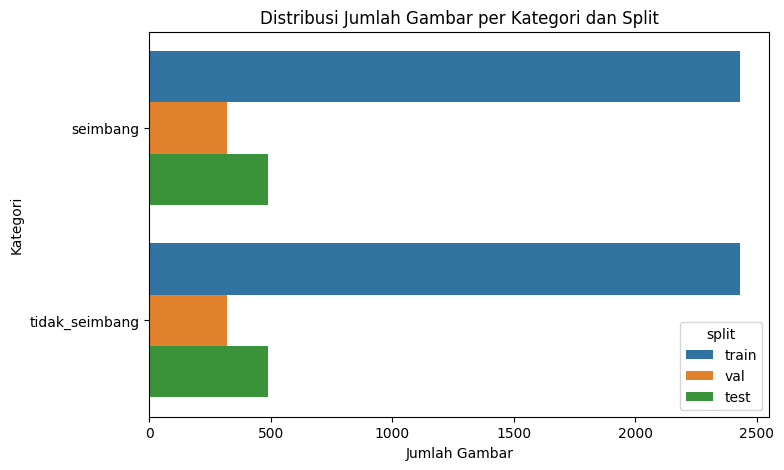

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi distribusi gambar
plt.figure(figsize=(8, 5))
sns.barplot(data=df_summary, x='num_images', y='label', hue='split')
plt.title('Distribusi Jumlah Gambar per Kategori dan Split')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kategori')
plt.show()

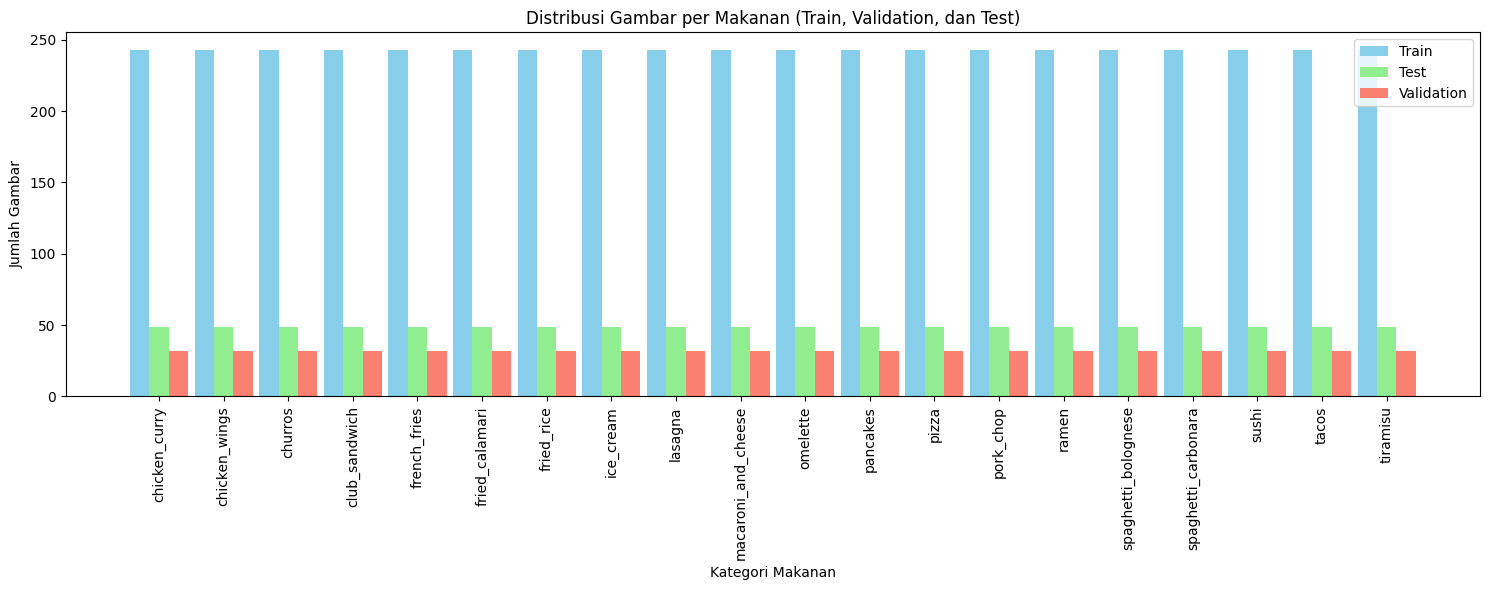

In [9]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Direktori dataset yang sudah dikelompokkan
output_dir = 'food101_split_binary'

# Fungsi untuk menghitung jumlah gambar per kategori
def count_images_per_category(base_dir, split='train'):
    counts = defaultdict(int)
    labels = ['seimbang', 'tidak_seimbang']

    for label in labels:
        label_dir = os.path.join(base_dir, split, label)
        if not os.path.exists(label_dir):
            print(f"Direktori {label_dir} tidak ditemukan!")
            continue
        # Dapatkan semua subfolder kategori makanan
        categories = [d for d in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, d))]
        for category in categories:
            category_dir = os.path.join(label_dir, category)
            num_images = len([f for f in os.listdir(category_dir) if f.endswith('.jpg')])
            counts[category] += num_images

    return counts

# Hitung distribusi untuk train, val, dan test
train_counts = count_images_per_category(output_dir, 'train')
val_counts = count_images_per_category(output_dir, 'val')
test_counts = count_images_per_category(output_dir, 'test')

# Gabungkan data untuk visualisasi
categories = sorted(set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys())))
train_data = [train_counts.get(cat, 0) for cat in categories]
test_data = [test_counts.get(cat, 0) for cat in categories]
val_data = [val_counts.get(cat, 0) for cat in categories]

# Visualisasi: Grafik Batang (Bar Chart)
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.3  # Sedikit diperkecil karena ada 3 bar
x = range(len(categories))


# Plot bar untuk train, test, dan val
plt.bar(x, train_data, bar_width, label='Train', color='skyblue')
plt.bar([i + bar_width for i in x], test_data, bar_width, label='Test', color='lightgreen')
plt.bar([i + 2 * bar_width for i in x], val_data, bar_width, label='Validation', color='salmon')


# Atur label dan judul
plt.xlabel('Kategori Makanan')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Gambar per Makanan (Train, Validation, dan Test)')
plt.xticks([i + bar_width for i in x], categories, rotation=90)
plt.legend()

# Atur layout agar rapi
plt.tight_layout()

# Tampilkan plot
plt.show()

In [10]:
from PIL import Image
import random
import os
import pandas as pd

# Fungsi untuk mengumpulkan informasi gambar
def collect_image_info(directory, num_samples=1000):
    info = []
    for split in ['train', 'test', 'val']:  # Tambahkan 'test' ke daftar split
        for label in ['seimbang', 'tidak_seimbang']:
            label_path = os.path.join(directory, split, label)
            if not os.path.exists(label_path):
                print(f"Direktori {label_path} tidak ditemukan!")
                continue

            # Dapatkan semua subfolder kategori makanan
            categories = [d for d in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, d))]

            for category in categories:
                path = os.path.join(label_path, category)
                images = [f for f in os.listdir(path) if f.endswith('.jpg')]  # Pastikan hanya file gambar
                if len(images) == 0:
                    continue
                sampled_images = random.sample(images, min(num_samples, len(images)))

                for img_name in sampled_images:
                    try:
                        img_path = os.path.join(path, img_name)
                        with Image.open(img_path) as img:
                            width, height = img.size
                            mode = img.mode
                            info.append({
                                'split': split,
                                'label': label,
                                'category': category,  # Tambahkan informasi kategori
                                'filename': img_name,
                                'width': width,
                                'height': height,
                                'mode': mode
                            })
                    except Exception as e:
                        info.append({
                            'split': split,
                            'label': label,
                            'category': category,  # Tambahkan informasi kategori
                            'filename': img_name,
                            'width': None,
                            'height': None,
                            'mode': 'corrupted'
                        })

    return pd.DataFrame(info)

# Jalankan fungsi
base_dir = 'food101_split_binary'  # Sesuaikan dengan direktori yang benar
df_images = collect_image_info(base_dir)
print("Informasi Gambar (Sampel):")
print(df_images.head())

# Statistik dimensi
print("\nStatistik Dimensi Gambar:")
print(df_images.groupby(['split', 'label', 'category'])[['width', 'height']].describe())

# Cek gambar korup
corrupted_images = df_images[df_images['mode'] == 'corrupted']
print(f"\nJumlah Gambar Korup: {len(corrupted_images)}")
if len(corrupted_images) > 0:
    print("Gambar Korup:")
    print(corrupted_images[['split', 'label', 'category', 'filename']])

Informasi Gambar (Sampel):
   split     label  category     filename  width  height mode
0  train  seimbang  omelette   621235.jpg    512     384  RGB
1  train  seimbang  omelette   630099.jpg    512     512  RGB
2  train  seimbang  omelette   821964.jpg    306     512  RGB
3  train  seimbang  omelette   595579.jpg    512     512  RGB
4  train  seimbang  omelette  1029915.jpg    512     512  RGB

Statistik Dimensi Gambar:
                                          width                                \
                                          count        mean        std    min   
split label          category                                                   
test  seimbang       chicken_curry         49.0  477.755102  57.579847  382.0   
                     club_sandwich         49.0  488.448980  50.165169  382.0   
                     fried_rice            49.0  488.346939  50.225139  382.0   
                     lasagna               49.0  498.877551  39.332786  382.0   
       

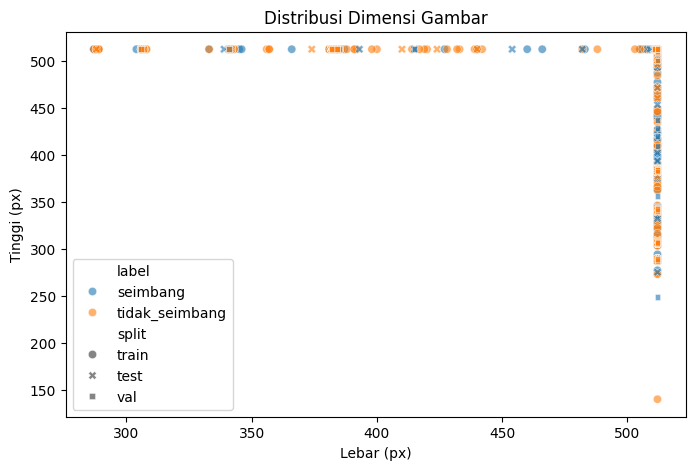

In [11]:
# Visualisasi distribusi dimensi
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_images, x='width', y='height', hue='label', style='split', alpha=0.6)
plt.title('Distribusi Dimensi Gambar')
plt.xlabel('Lebar (px)')
plt.ylabel('Tinggi (px)')
plt.show()

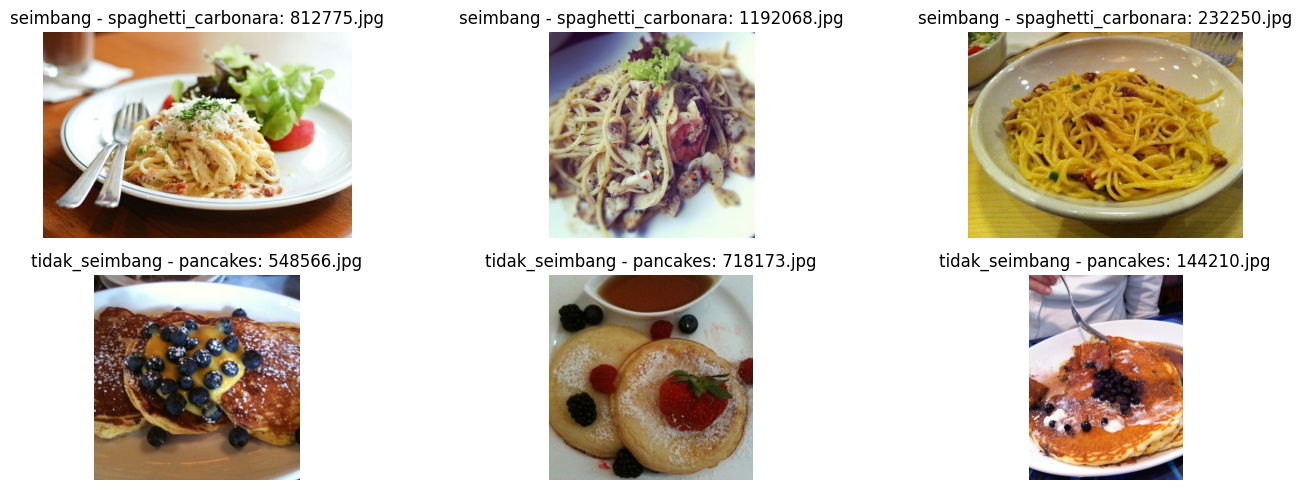

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random

# Fungsi untuk menampilkan sampel gambar
def display_sample_images(directory, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    labels = ['seimbang', 'tidak_seimbang']

    for i, label in enumerate(labels):
        label_path = os.path.join(directory, 'train', label)
        if not os.path.exists(label_path):
            print(f"Direktori {label_path} tidak ditemukan!")
            continue

        # Dapatkan semua subfolder kategori makanan
        categories = [d for d in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, d))]
        if not categories:
            print(f"Tidak ada kategori di {label_path}!")
            continue

        # Pilih satu kategori secara acak untuk setiap label
        selected_category = random.choice(categories)
        category_path = os.path.join(label_path, selected_category)
        images = [f for f in os.listdir(category_path) if f.endswith('.jpg')]

        if len(images) == 0:
            print(f"Tidak ada gambar di {category_path}!")
            continue

        sampled_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(sampled_images):
            img_path = os.path.join(category_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{label} - {selected_category}: {img_name}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Jalankan fungsi
base_dir = 'food101_split_binary'  # Sesuaikan dengan direktori yang benar
display_sample_images(base_dir)

Statistik Ukuran File Gambar (KB):
                                          count       mean        std  \
split label          category                                           
train seimbang       chicken_curry        243.0  48.118654  13.778903   
                     club_sandwich        243.0  50.086761  15.198385   
                     fried_rice           243.0  51.818508  16.006617   
                     lasagna              243.0  49.929888  13.477651   
                     macaroni_and_cheese  243.0  44.095900  12.487628   
                     omelette             243.0  49.360862  14.069262   
                     pork_chop            243.0  48.392466  15.242357   
                     ramen                243.0  50.872368  16.759921   
                     spaghetti_carbonara  243.0  49.157399  13.194081   
                     sushi                243.0  45.919649  14.028882   
      tidak_seimbang chicken_wings        243.0  49.919395  16.426067   
                

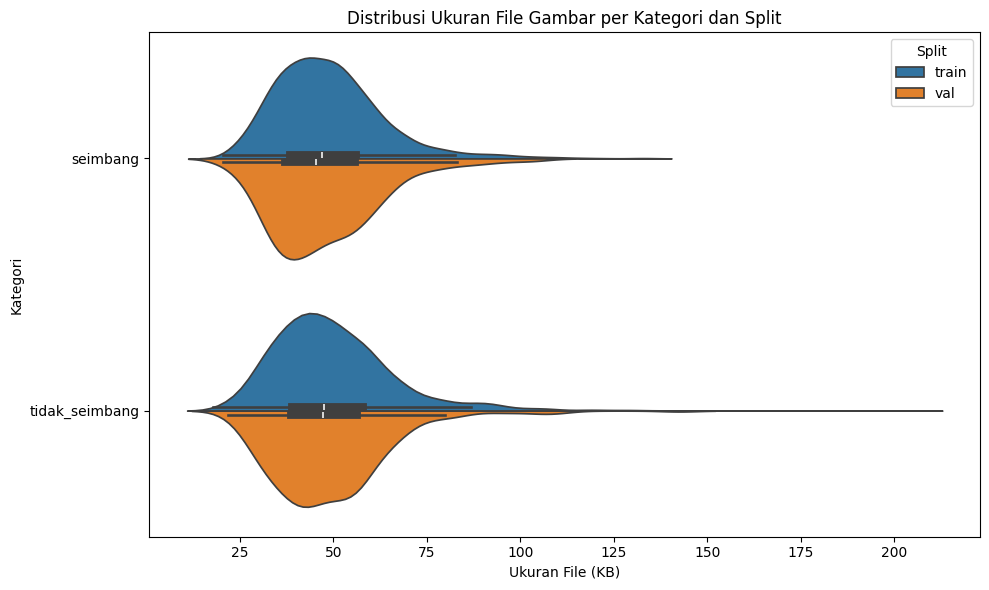

In [13]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fungsi untuk mengumpulkan ukuran file gambar
def calculate_file_size(directory, num_samples=1000):
    file_size_data = []
    for split in ['train', 'val']:
        for label in ['seimbang', 'tidak_seimbang']:
            label_path = os.path.join(directory, split, label)
            if not os.path.exists(label_path):
                print(f"Direktori {label_path} tidak ditemukan!")
                continue

            # Dapatkan semua subfolder kategori makanan
            categories = [d for d in os.listdir(label_path) if os.path.isdir(os.path.join(label_path, d))]
            if not categories:
                print(f"Tidak ada kategori di {label_path}!")
                continue

            for category in categories:
                category_path = os.path.join(label_path, category)
                images = [f for f in os.listdir(category_path) if f.endswith('.jpg')]
                if len(images) == 0:
                    continue
                sampled_images = random.sample(images, min(num_samples, len(images)))

                for img_name in sampled_images:
                    try:
                        img_path = os.path.join(category_path, img_name)
                        file_size = os.path.getsize(img_path) / 1024  # Ukuran dalam KB
                        file_size_data.append({
                            'split': split,
                            'label': label,
                            'category': category,  # Tambahkan informasi kategori
                            'file_size_kb': file_size
                        })
                    except Exception as e:
                        print(f"Error memproses {img_path}: {e}")
                        continue

    return pd.DataFrame(file_size_data)

# Jalankan fungsi
base_dir = 'food101_split_binary'  # Sesuaikan dengan direktori yang benar
df_file_size = calculate_file_size(base_dir)
print("Statistik Ukuran File Gambar (KB):")
print(df_file_size.groupby(['split', 'label', 'category'])['file_size_kb'].describe())

# Visualisasi distribusi ukuran file
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_file_size, x='file_size_kb', y='label', hue='split', split=True)
plt.title('Distribusi Ukuran File Gambar per Kategori dan Split')
plt.xlabel('Ukuran File (KB)')
plt.ylabel('Kategori')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

# Augmentasi

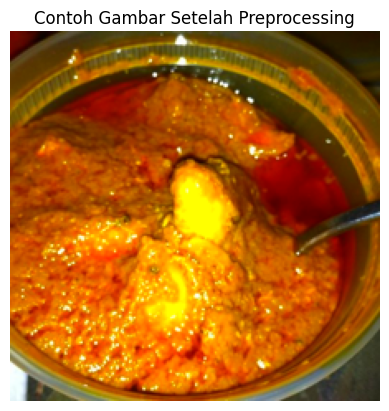

In [14]:
from PIL import Image, ImageEnhance
import numpy as np

def clean_image(image_path, target_size=(224, 224), saturation_factor=1.5):
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize(target_size)
    enhancer = ImageEnhance.Color(img_resized)
    img_enhanced = enhancer.enhance(saturation_factor)
    img_array = np.array(img_enhanced) / 255.0
    return img_array

# Contoh uji coba membersihkan satu gambar
sample_path = '/content/extracted_dataset/300 - Copy/chicken_curry/1004867.jpg'  # pastikan file ini ada
cleaned = clean_image(sample_path)

import matplotlib.pyplot as plt
plt.imshow(cleaned)
plt.title("Contoh Gambar Setelah Preprocessing")
plt.axis('off')
plt.show()


## **Modelling**


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Gunakan folder hasil split sebelumnya
final_train_dir = '/content/food101_split_binary/train'
val_dir = '/content/food101_split_binary/val'
test_dir = '/content/food101_split_binary/test'

# --- ImageDataGenerator Setup ---

target_size = (150, 150)
batch_size = 32

# Augmentasi untuk data latih
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari folder ke generator
train_generator = train_datagen.flow_from_directory(
    final_train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4860 images belonging to 2 classes.
Found 640 images belonging to 2 classes.
Found 980 images belonging to 2 classes.


In [16]:
# Menampilkan kelas-kelas yang terdapat dalam dataset
print("Kelas-kelas dalam dataset:")
for class_name, index in train_generator.class_indices.items():
    print(f"{index}: {class_name}")

Kelas-kelas dalam dataset:
0: seimbang
1: tidak_seimbang


In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load base model MobileNetV2 tanpa top layers
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Bekukan beberapa layer awal
for layer in base_model.layers[:100]:  # Misal bekukan 100 layer pertama
    layer.trainable = False

# Tambahkan custom top layers
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

# Output layer (jumlah kelas disesuaikan)
num_classes = len(train_generator.class_indices)
predictions = Dense(num_classes, activation='softmax')(x)

# Gabungkan ke model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

<ipython-input-30-df80f7786bd4>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 3,018,274 (11.51 MB)

 Trainable params: 2,621,730 (10.00 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [31]:
# Kompilasi model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
save_best = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

stop_early = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
    mode='max',
    baseline=0.96
)

In [34]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[stop_early]
)

Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.7938 - loss: 0.4492 - val_accuracy: 0.7531 - val_loss: 0.5641
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.8212 - loss: 0.3854 - val_accuracy: 0.7578 - val_loss: 0.5932
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 237ms/step - accuracy: 0.8462 - loss: 0.3629 - val_accuracy: 0.7891 - val_loss: 0.5227
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.8718 - loss: 0.2945 - val_accuracy: 0.7984 - val_loss: 0.5156
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.8938 - loss: 0.2617 - val_accuracy: 0.7937 - val_loss: 0.5048


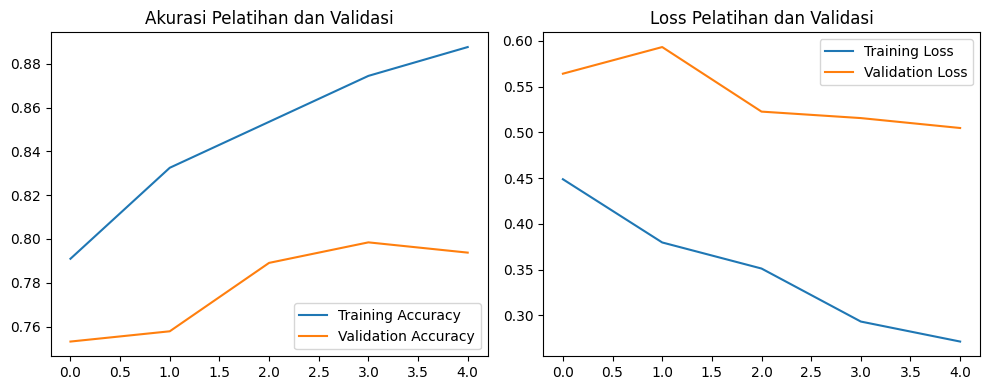

In [35]:
# Misalnya history adalah hasil dari model.fit(...)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot Akurasi
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Akurasi Pelatihan dan Validasi')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss Pelatihan dan Validasi')

plt.tight_layout()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7910 - loss: 0.5051

 Test Accuracy: 82.65%
 Test Loss: 0.4349



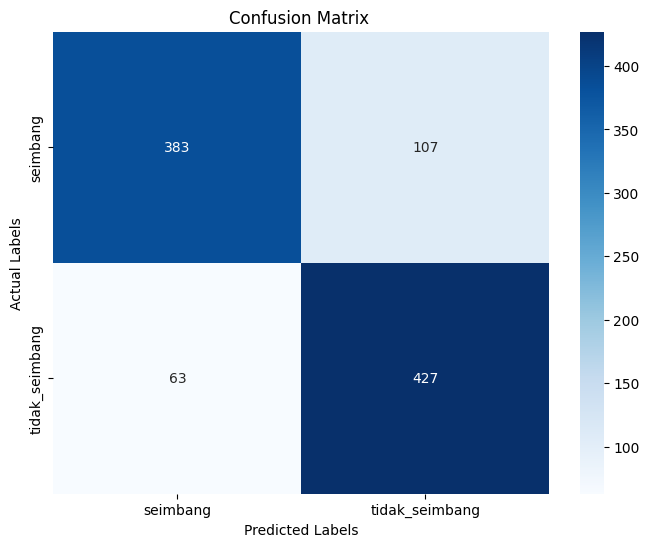

 Classification Report:
                precision    recall  f1-score   support

      seimbang     0.8587    0.7816    0.8184       490
tidak_seimbang     0.7996    0.8714    0.8340       490

      accuracy                         0.8265       980
     macro avg     0.8292    0.8265    0.8262       980
  weighted avg     0.8292    0.8265    0.8262       980



In [36]:
from sklearn.metrics import classification_report, confusion_matrix

# Reset test generator untuk memastikan evaluasi dari awal
test_generator.reset()

# Evaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f"\n Test Accuracy: {accuracy*100:.2f}%")
print(f" Test Loss: {loss:.4f}\n")

# Prediksi kelas
preds = model.predict(test_generator, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix ")
plt.show()

# Classification Report
print(" Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

In [37]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# Muat model .h5
model = tf.keras.models.load_model('model.h5')

# Simpan ke format SavedModel menggunakan tf.saved_model.save
saved_model_path = '/content/saved_model'
tf.saved_model.save(model, saved_model_path)

# Kompres folder SavedModel jadi zip
shutil.make_archive('saved_model', 'zip', saved_model_path)

# Download file zip
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
# Memuat model Keras
model = tf.keras.models.load_model('model.h5')

# Konversi ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Pastikan direktori tujuan ada
os.makedirs('/content/tflite', exist_ok=True)

# Simpan model TensorFlow Lite
tflite_model_path = '/content/tflite/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Simpan label
label_path = '/content/tflite/label1.txt'
with open(label_path, 'w') as f:
    f.write("0: Seimbang\n1: Tidak_seimbang")

print("Model berhasil dikonversi dan disimpan ke TensorFlow Lite ")

# Download file TFLite dan label
files.download(tflite_model_path)
files.download(label_path)

Saved artifact at '/tmp/tmpsvlodrxm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137880051980560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679361296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679373968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137880051979408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679368016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679372816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679372624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679372240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679372432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679367440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137877679370896

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Muat model Keras (.h5)
model = tf.keras.models.load_model('model.h5')

# Tentukan direktori penyimpanan model TFJS
tfjs_model_dir = '/content/tfjs_model'

# Konversi ke format TFJS
tfjs.converters.save_keras_model(model, tfjs_model_dir)
print(f"Model TensorFlow.js disimpan di: {tfjs_model_dir}")

# Kompres ke format .zip
zip_path = shutil.make_archive(tfjs_model_dir, 'zip', tfjs_model_dir)

# Unduh file .zip
files.download(zip_path)

failed to lookup keras version from the file,
    this is likely a weight only file
Model TensorFlow.js disimpan di: /content/tfjs_model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# Label mapping
labels = ["seimbang", "tidak_seimbang"]

# Path ke gambar untuk tiap kelas
image_paths = {
    "omlette": "/content/contoh_data/images.jpeg",
    "ice_cream": "/content/contoh_data/download.jpeg",
    "chicken_wings":"/content/contoh_data/fire-chicken-wings.jpg",
    "sandwich":"/content/contoh_data/images (1).jpeg"
}

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='tflite/model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prediksi dan visualisasi
plt.figure(figsize=(15, 5))  # Perbesar lebar figure untuk memberikan lebih banyak ruang
for i, (label_name, img_path) in enumerate(image_paths.items()):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32) / 255.0

    # Set input
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Run inference
    interpreter.invoke()

    # Ambil hasil prediksi
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output)
    confidence = np.max(output)

    # Visualisasi
    plt.subplot(1, 5, i + 2)  # Gunakan posisi 2 dan 4 untuk memberikan spasi di tengah
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Asli: {label_name}\nPrediksi: {labels[predicted_class]} ({confidence*100:.2f}%)")

# Tambahkan spasi antar subplot
plt.subplots_adjust(wspace=0.5)  # Tingkatkan jarak horizontal
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/contoh_data/images.jpeg'

<Figure size 1500x500 with 0 Axes>